<a href="https://colab.research.google.com/github/sara2cb/Learning-Machine-Learning/blob/main/Learning_with_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instructions:
1. Use the comments provided to help you.
2. Write code only in the sections indicated by our comments. You can add training hyper-parameters of your choice in the training cells
3. The dataset and trained model folders should be **one level above** your notebook - that is, "../Datasets", "../trained_models" etc.  
   Suggested directory structure:  
   Root Folder/  
     - Datasets/  
     - Models/  
     - Src/  
       - CW2.ipynb  

In [ ]:

import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time


In [ ]:
#Function to plot multiple images specifying number of rows
def gallery_rows(array, nrows=3):
  nindex, height, width, intensity = array.shape
  ncols = nindex*nrows
  assert nindex == nrows*ncols
  result = (array.reshape(nrows, ncols, height, width, intensity)
            .swapaxes(1,2)
            .reshape(height*nrows, width*ncols, intensity))
  return result

#Function to plot multiple images specifying number of columns
def gallery(array, ncols=3):
  nindex, height, width, intensity = array.shape
  nrows = nindex//ncols
  assert nindex == nrows*ncols
  # want result.shape = (height*nrows, width*ncols, intensity)
  result = (array.reshape(nrows, ncols, height, width, intensity)
            .swapaxes(1,2)
            .reshape(height*nrows, width*ncols, intensity))
  return result

## Question 1: Filtering in 1D and 2D
### Part 1a) Implement a filter to remove low frequencies from the audio fileaudio.npy.  Plot the input and outputof your filter as line graphs. **(5 points)**
---
Complete this question by implementing the function `highpass_filter_audio` below, and plotting the output. Reminder: Your implementation of highpass_filter_audioshould only use numpy. You may use other libraries to display your results.

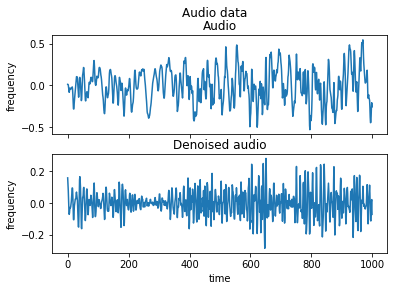

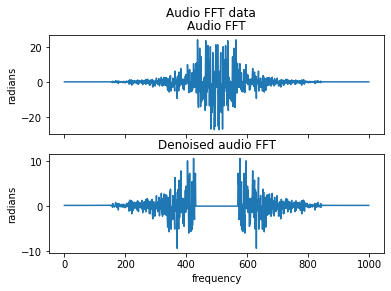

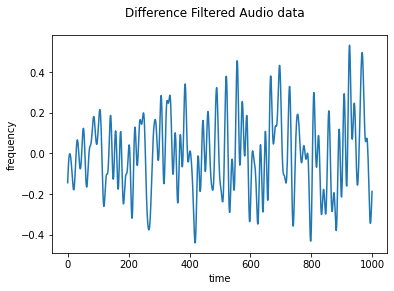

In [ ]:
input_audio_filename = "../Datasets/Filtering/audio.npy

# LOAD input_audio FROM input_audio_filename
input_audio = np.load(input_audio_filename)

def highpass_filter_audio(audio):
    # IMPLEMENT THIS FUNCTION
    #Array to store the filtered fft audio, get the current fft of the audio
    filtered =  np.fft.fftshift(np.fft.fft(audio))
    #Frequency of the audio
    fr =np.fft.fftfreq(audio.size)
    #Get half of the ffc since it is symmetric
    sym = fr[:int(len(audio)/2)]

    #Array to store the difference of the filtered fft audio, get the current 
    # fft of the audio
    diff =  np.fft.fftshift(np.fft.fft(audio))
    for f in range(len(sym)):
      #Filter high frequencies to remove noise
      if sym[f] < 0.07:
        filtered[len(audio) // 2 - f] = 0
        filtered[len(audio) // 2 + f] = 0
      #Difference of audio
      else:
        diff[len(audio) // 2 - f] = 0
        diff[len(audio) // 2 + f] = 0
    #Inverse of the fft to get the original audio
    return np.real(np.fft.ifft(np.fft.ifftshift(filtered))) , np.real(np.fft.ifft(np.fft.ifftshift(diff)))

filtered_audio, diff = highpass_filter_audio(input_audio)

# PLOT input_audio AND filtered_audio
#Plot the audio 
fig, axs = plt.subplots(2)
fig.suptitle('Audio data')
axs[0].plot(input_audio)
axs[0].set(xlabel='time', ylabel='frequency')
axs[0].set_title('Audio')
axs[0].label_outer()
axs[1].plot(filtered_audio)
axs[1].set(xlabel='time', ylabel='frequency')
axs[1].set_title('Denoised audio')

#Plot the audio fft
fig, axs = plt.subplots(2)
fig.suptitle('Audio FFT data')
axs[0].plot(np.real(np.fft.fftshift(np.fft.fft(input_audio))))
axs[0].set(xlabel='frquency', ylabel='radians')
axs[0].set_title('Audio FFT')
axs[0].label_outer()
axs[1].plot(np.real(np.fft.fftshift(np.fft.fft(filtered_audio))))
axs[1].set(xlabel='frequency', ylabel='radians')
axs[1].set_title('Denoised audio FFT')

#Plot the difference
fig, axs = plt.subplots(1)
fig.suptitle('Difference Filtered Audio data')
axs.plot(diff)
axs.set(xlabel='time', ylabel='frequency')
axs.label_outer()

### Part 1b) Implement a filter to find vertical edges in an image.  We provide a sample fileimage.pngfor testing. Apply your filter to this image and display the input and output of your filter. **(10 points)**
---
Implement the function `detect_vertical_edges` below. This should apply a filter to detect vertical edges in the supplied input image. That is, your implementation should output a grayscale image of the same width and height as the input, with high values where vertical edges are present in the input image and low values elsewhere. Test your code on the supplied image.png. Display the input image and your output to demonstrate your implementation works correctly. Reminder: Your implementation of detect_vertical_edges should only use numpy. You may use other libraries to display your results.

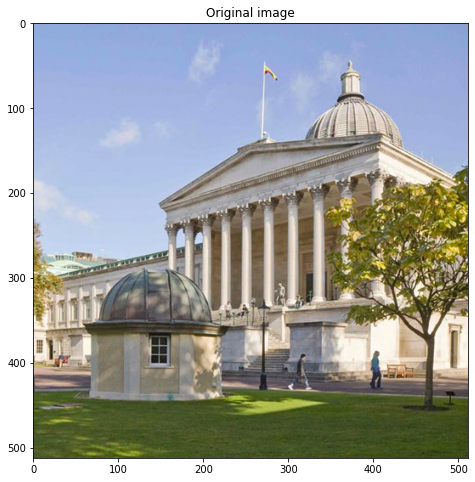

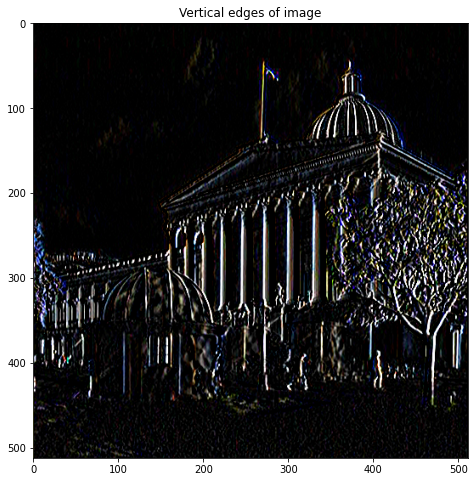

In [ ]:
input_image_filename = "../Datasets/Filtering/image.png"

# LOAD input_image FROM input_image_filename
input_image = np.array(mpimg.imread(input_image_filename))

def detect_vertical_edges(image):
    # IMPLEMENT THIS FUNCTION
    #Define kernel, this will get any edges that has a big difference of colour 
    # compared to its vertical neighbours
    kernel = np.array([[-1,0,1],\
                       [-2,0,2],\
                       [-1,0,1]])
    #Define kernel size
    kernelSize = len(kernel)
    #Size of the padding needed
    kerPad = int((kernelSize-1)/2)
    #Padding the image with zeros
    imagePadded = np.vstack((np.zeros((kerPad, len(image[0]), 4)),\
                            image,\
                            np.zeros((kerPad, len(image[0]), 4))))
    imagePadded = np.hstack((np.zeros((len(imagePadded), kerPad, 4)),\
                            imagePadded,\
                            np.zeros((len(imagePadded), kerPad, 4))))
    filtered_image = np.copy(imagePadded)
    
    #Go thorugh each pixel of the unpadded image
    lengthNoPad = len(filtered_image)-kerPad
    lengthNoPadY = len(filtered_image[0])-kerPad
    for x in range(kerPad, lengthNoPad):
        for y in range(kerPad, lengthNoPadY):
          #Get the window image of the current pixel to apply to kernel
          windowImage = imagePadded[x-kerPad:x+kerPad+1, y-kerPad:y+kerPad+1, :]
          #Apply kernel
          filtered_image[x, y, 0] = np.sum(kernel * windowImage[:,:,0])
          filtered_image[x, y, 1] = np.sum(kernel * windowImage[:,:,1])
          filtered_image[x, y, 2] = np.sum(kernel * windowImage[:,:,2])
    #Remove padding
    filtered = filtered_image[kerPad:lengthNoPad, kerPad:lengthNoPadY]
    return np.clip(filtered,0,1)

filtered_image = detect_vertical_edges(input_image)

# DISPLAY input_image AND filtered_image here
#Plot original image
plt.figure(figsize=(8, 8))
imgplot = plt.imshow(input_image)
plt.title('Original image')
plt.show()

#Plot vertical edges of the image
plt.figure(figsize=(8, 8))
imgplot = plt.imshow(filtered_image)
plt.title('Vertical edges of image')
plt.show()

## Question 2: Denoising
### Part 2a) Implement denoise_gauss to denoise an image using a 5×5 Gaussian filter.  **(5 points)**
---

Implement the `denoise_gauss` function below. This should apply a 5x5 gaussian filter to a supplied noisy image, returning an output of the same dimensions. Show results on the supplied noisy_image.png.

Reminder: Your implementation for denoise_gauss should only use numpy. You may use other libraries to display your results.

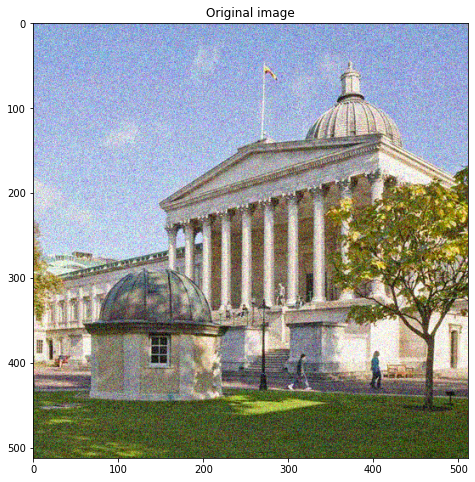

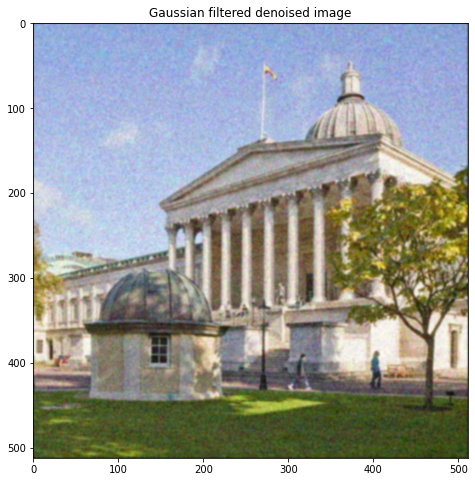

In [ ]:
noisy_image_filename = "../Datasets/Filtering/noisy_image.png"

# LOAD noisy_image FROM noisy_image_filename
noisy_image = mpimg.imread(noisy_image_filename)

def denoise_gauss(image):
    # IMPLEMENT THIS FUNCTION
    #Define kernel to blur each pixel depending on the pixels surrounding them 
    kernel = np.array([[1, 4,  7,  4,  1],\
                       [4, 16, 26, 16, 4],\
                       [7, 26, 41, 26, 7],\
                       [4, 16, 26, 16, 4],\
                       [1, 4,  7,  4,  1]])
    #Define kernel size
    kernelSize = len(kernel)
    #Size of the padding needed
    kerPad = int((kernelSize-1)/2)
    #Padding the image with zeros
    imagePadded = np.vstack((np.zeros((kerPad, len(image[0]), 3)),\
                            image,\
                            np.zeros((kerPad, len(image[0]), 3))))
    imagePadded = np.hstack((np.zeros((len(imagePadded), kerPad, 3)),\
                            imagePadded,\
                            np.zeros((len(imagePadded), kerPad, 3))))
    denoised_image = np.copy(imagePadded)
    
    #Go thorugh each pixel of the unpadded image
    lengthNoPad = len(denoised_image)-kerPad
    lengthNoPadY = len(denoised_image[0])-kerPad
    for x in range(kerPad, lengthNoPad):
        for y in range(kerPad, lengthNoPadY):
          #Get the window image of the current pixel to apply to kernel
          windowImage = imagePadded[x-kerPad:x+kerPad+1, y-kerPad:y+kerPad+1, :]
          #Apply kernel
          denoised_image[x, y, 0] = np.sum(kernel * windowImage[:,:,0])
          denoised_image[x, y, 1] = np.sum(kernel * windowImage[:,:,1])
          denoised_image[x, y, 2] = np.sum(kernel * windowImage[:,:,2])
    #Remove padding
    denoised = denoised_image[kerPad:lengthNoPad, kerPad:lengthNoPadY]
    return (denoised - np.min(denoised))/(np.max(denoised)- np.min(denoised))

denoised_image = denoise_gauss(noisy_image)

# DISPLAY input_image AND denoised_image here
#Plot original image
plt.figure(figsize=(8, 8))
imgplot = plt.imshow(noisy_image)
plt.title('Original image')
plt.show()
#Plot denoised image
plt.figure(figsize=(8, 8))
imgplot = plt.imshow(denoised_image)
plt.title('Gaussian filtered denoised image')
plt.show()

### Part 2b) Implement a pyramidal encoder-decoder to denoise an image.  We provide you pairs of noisy and noise-free image patches of size 128×128 for training and testing. You may use all the infrastructure of Pytorch. The encoder should have 5 levels and double(half) the number of internal activations when reducing (increasing) the spatial resolution. Please use ReLU non-linearities after each layer **(15 points)**
---

Implement following cell, to solve this question.

Training noisy images


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 of 500, Train Loss: 0.158, duration (s): 2.11
Epoch 51 of 500, Train Loss: 0.058, duration (s): 2.13
Epoch 101 of 500, Train Loss: 0.034, duration (s): 2.21
Epoch 151 of 500, Train Loss: 0.016, duration (s): 2.15
Epoch 201 of 500, Train Loss: 0.009, duration (s): 2.14
Epoch 251 of 500, Train Loss: 0.007, duration (s): 2.15
Epoch 301 of 500, Train Loss: 0.006, duration (s): 2.03
Epoch 351 of 500, Train Loss: 0.005, duration (s): 2.05
Epoch 401 of 500, Train Loss: 0.004, duration (s): 2.11
Epoch 451 of 500, Train Loss: 0.004, duration (s): 2.12
Epoch 500 of 500, Train Loss: 0.004, duration (s): 2.13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

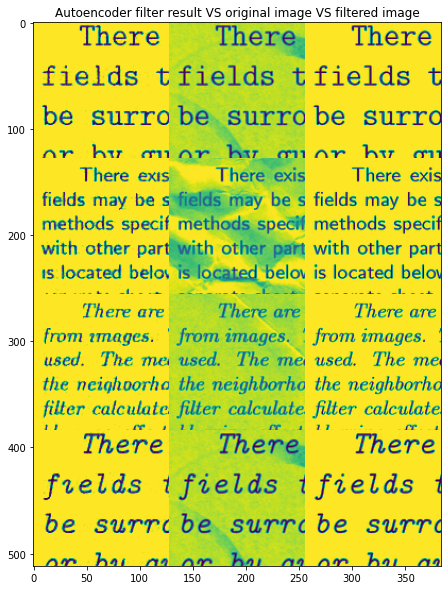

In [ ]:
input_imgs_path = "../Datasets/Denoising/input_noisy_images"
cleaned_imgs_path = "../Datasets/Denoising/target_clean_images"

epochs =500 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS
BATCHSIZE = 1

class DenoisingDB(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        #Get all the files inside the path specified
        self.cleanImages = os.listdir(cleaned_imgs_path)
        self.noisyImages = os.listdir(input_imgs_path)
        self.cleanImagesPath = cleaned_imgs_path + "/"
        self.noisyImagesPath = input_imgs_path + "/"

    def __len__(self):
        # RETURN SIZE OF DATASET
        #Retirn the length of the directory file
        length = len(self.cleanImages)
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        #Get the noisy and the clean file from the directory
        noisyImage = mpimg.imread(self.noisyImagesPath + self.noisyImages[idx])
        cleanImage = mpimg.imread(self.cleanImagesPath + self.cleanImages[idx])
        #Crop the image to only get a 128x128 image
        image = np.array([noisyImage[0:0+128,0:0+128],\
                          cleanImage[0:0+128,0:0+128]])
        return image

class Encoder(Module):
  # IMPLEMENT THIS ENCODER CLASS
    def __init__(self):
        super(Encoder, self).__init__()
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        #Defining the parameters of the encoder
        self.noPixels = 8
        self.noChannels = int(noPixels*(2**4))
        self.height = int(128 / 2**5)
        self.width = int(128 / 2**5)
        self.flattening = self.noChannels * self.height * self.width
        self.bottleneck = 2000
        #In this model we included 5 convolutional layers, and then making sure
        # to reduce the number of features depending on the bottleneck. We have
        # to make sure that stride is 2 to half the resolution of the image each
        # layer
        self.model = nn.Sequential(
            nn.Conv2d(BATCHSIZE, noPixels, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(noPixels, int(noPixels*2), kernel_size=3, padding=1, \
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noPixels*2), int(noPixels*(2**2)), kernel_size=3, \
                      padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noPixels*(2**2)), int(noPixels*(2**3)),kernel_size=3,\
                      padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noPixels*(2**3)), int(noPixels*(2**4)),kernel_size=3,\
                      padding=1, stride=2),
            nn.Flatten(),
            nn.Linear(self.flattening, self.bottleneck),
            nn.ReLU()
        )

    def forward(self,high_res_image):
        # WRITE YOUR ENCODER ARCHITECTURE HERE
        #Call the encoder
        low_res_image = self.model(high_res_image)
        return low_res_image

class Decoder(Module):
  # IMPLEMENT THIS DECODER CLASS
    def __init__(self):
        super(Decoder, self).__init__()
        #Include an encoder  in the decoder
        self.encoder = Encoder()
        #Firstly we undo the bottleneck layer and bring back the number of 
        # features, then we include 5 convolution layer to decode the encoder. 
        # We have to make sure that stride is 2 to double the resolution of the 
        # image each layer
        self.model = nn.Sequential(
            nn.Linear(self.encoder.bottleneck, self.encoder.flattening),
            nn.ReLU(),
            nn.Unflatten(1, (self.encoder.noChannels,  self.encoder.height, \
                             self.encoder.width)),
            nn.ConvTranspose2d(int(self.encoder.noPixels*(2**4)), \
                               int(self.encoder.noPixels*(2**4)), \
                               kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(int(self.encoder.noPixels*(2**4)), \
                               int(self.encoder.noPixels*(2**3)), \
                               kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(int(self.encoder.noPixels*(2**3)), \
                               int(self.encoder.noPixels*(2**2)), \
                               kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(int(self.encoder.noPixels*(2**2)), \
                               int(self.encoder.noPixels*2), \
                               kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(int(self.encoder.noPixels*2), \
                               self.encoder.noPixels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(self.encoder.noPixels, BATCHSIZE, kernel_size=3,padding=1),
            nn.Sigmoid()
        )
        
    def forward(self,low_res_image):
        # WRITE YOUR DECODER ARCHITECTURE HERE
        #Call the encoder and then the decoder
        denoised_image = self.encoder.forward(low_res_image)
        denoised_image = self.model(denoised_image)
        return denoised_image
        
def loss_function(input,target):
    # WRITE YOUR DENOISING LOSS FUNCTION HERE
    #Implement the pytorch Mean Squared Loss
    mseLoss = nn.MSELoss()
    loss = mseLoss(input, target)
    return loss

#Use GPU if possible
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
decNet = Decoder().to(device)

# USE THE TORCH API TO WRITE YOUR Stochastic Gradient Descent 
#  optimizer function here.
optimizerDec = torch.optim.Adam(decNet.parameters(), lr=0.0001)
docs_dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)
torch_train_docs = DataLoader(docs_dataset,shuffle=True,batch_size=BATCHSIZE,\
                              num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

#Lists to save the images to plot and the loss history
lastOutput = []
print('Training noisy images')
for ep in range(epochs):
  #Variable to calculate epoch loss and duration
  runningLoss = 0
  begtime = time.time()

  for i,data in enumerate(torch_train_docs):
    # WRITE YOUR CelebA TRAINING LOOP HERE.
    #Extract images
    img_noisy = data[:,0].to(device)
    img_clean = data[:, 1].to(device)
    #Setting gradients to zero
    optimizerDec.zero_grad()
    #Apply image to CNN
    outputs = decNet(img_noisy[None, ...].to(device))
    #Calculate loss
    loss = loss_function(outputs.to(device), img_clean)
    #Back propagation
    loss.backward()
    #Parameter update
    optimizerDec.step()
    #Update the loss
    runningLoss += loss.item()
    #For the last 5 images, store the results
    if ep == epochs -1 and i > docs_dataset.__len__()-5:
      lastOutput.append(outputs.cpu().detach().numpy()[0,0])
      lastOutput.append(data[:,0].cpu().detach().numpy()[0])
      lastOutput.append(data[:,1].cpu().detach().numpy()[0])

  #Calculate average loss of the epoch
  loss = runningLoss / len(torch_train_docs)
  #Calculate Epoch duration
  finalTime = time.time() - begtime
  #Print epoch info 
  if ep % (epochs/10) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Train Loss: {:.3f}, duration (s): {:.2f}'.format(\
              ep+1, epochs, loss, finalTime))

#Plot the resulting images
gal = gallery(np.array(np.array(lastOutput).reshape(3*4,128,128, 1)), 3)
gal = gal.reshape(len(gal), len(gal[0]))
plt.figure(figsize=(10, 10))
plt.imshow(gal)
plt.title('Autoencoder filter result VS original image VS filtered image')
plt.show()

torch._C._cuda_emptyCache()


### Part 2c) Write a markdown block, comparing the Gaussian and encoder-decoder denoising methods.  Include example output images from each method and discuss which method performs better and where.  You should write no more than half a page.  **(5 points)**
---

When it comes to denoising, the encoder-decoder is more efficient. We can see in the results that the text is stripped from the background noise (what would be the page’s folds) and in the gaussian filter, there is still some background noise in the image. In addition, the Gaussian results in a blurry image compared to the original, which makes sense since that is what the kernel we gave it essentially does, blurring each pixel to match more the pixels surrounding it.  The reason the encoder-decoder works better is because it is training to find a kernel that differentiates and highlights the important features of the image, in this case, the text. In addition, the encoder-decoder would work with multiple MIP levels and gaussian would only work on the lowest MIP level.

However, it is important to mention that the Gaussian filter requires no training or any preprocessing, while the encoder-decoder can take 15 minutes to train. It is true though that once trained, the encoder-decoder model can filter images much faster than the Gaussian which takes a couple of seconds.

The following images show the filtered result of the same dataset and the original image. The image on the left is the Gaussian filter and the right one the encoder-decoder, showing the much better results of the encoder.


![](https://drive.google.com/uc?export=view&id=1O4P_0RZfatspaUsRL3yYQWaif2mOUw6X)

## Question 3: Auto-Encoder
### Part 3a) Implement a convolutional auto-encoder (AE). The loss between in and output should be L2.  You canmake use of all the convolution, pooling, back-propagation and build-in functionality of Pytorch here. **(15 points)**
---
Solve this question by implementing the AutoEncoder class below

In [ ]:
class AutoEncoder(Module):
    # IMPLEMENT THIS AUTO-ENCODER CLASS
    def __init__(self,bottleneck_size):
        super(AutoEncoder, self).__init__()
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.

        #Define the parameters of the CNN
        noActivations = 128
        kernel_size = 5
        self.noChannels = int(noActivations)
        self.height = int(128 / 2**5)
        self.width = int(128 / 2**5)
        self.flattening = self.noChannels * self.height * self.width
        self.bottleneck = bottleneck_size

        #In this model we included 5 convolutional layers during encoding, and 
        # then we make sure to reduce the number of features depending on the 
        # bottleneck. We have to make sure that stride is 2 to half the 
        # resolution of the image each layer
        self.modelEnc = nn.Sequential(
            nn.Conv2d(3, int(noActivations/(2**4)), kernel_size=kernel_size, \
                      padding=(kernel_size-1)//2, stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/(2**4)), int(noActivations/(2**3)),\
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/(2**3)), int(noActivations/(2**2)), \
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/(2**2)), int(noActivations/2), \
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/2), noActivations, \
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.Flatten(),
            nn.Linear(self.flattening, self.bottleneck),
            nn.ReLU()
        )

        #During decoding firstly, we undo the bottleneck layer and bring back 
        # the number of features, then we include 5 convolution layer to decode 
        # the encoder. We have to make sure that stride is 2 to double the 
        # resolution of the image each layer
        self.modelDec = nn.Sequential(
            nn.Linear(self.bottleneck, self.flattening),
            nn.ReLU(),
            nn.Unflatten(1, (self.noChannels,  self.height, self.width)),
            nn.ConvTranspose2d(noActivations, noActivations,\
                               kernel_size=kernel_size, \
                               padding=(kernel_size-1)//2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(noActivations, int(noActivations/2), \
                               kernel_size=kernel_size, \
                               padding=(kernel_size-1)//2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(int(noActivations/2), int(noActivations/(2**2)),\
                               kernel_size=kernel_size, \
                               padding=(kernel_size-1)//2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(int(noActivations/(2**2)), \
                               int(noActivations/(2**3)), \
                               kernel_size=kernel_size, \
                               padding=(kernel_size-1)//2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(int(noActivations/(2**3)), \
                               int(noActivations/(2**4)), \
                               kernel_size=kernel_size, \
                               padding=(kernel_size-1)//2, stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/(2**4)), 3, kernel_size=kernel_size, \
                      padding=(kernel_size-1)//2),
            nn.Sigmoid(),
        )

    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        #Call the encoder model
        code = self.modelEnc(image)
        return code
    
    def decoder(self,code):
        # WRITE DECODER ARCHITECTURE HERE
        # Call the decoder model 
        decoded_image = self.modelDec(code)
        #Interpolate the image to have the size expected
        decoded_image =nn.functional.interpolate(decoded_image, \
                                                 (self.width*2**5, \
                                                  self.height*2**5))
        return decoded_image
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        encoded_image = self.encoder(image)
        decoded_image = self.decoder(encoded_image)
        return decoded_image

### Part 3b) Test it on the CelebA and MNIST dataset by encoding and decoding their first 5 samples. Compile results showing for each of the dataset and for each sample the input and the AE reconstruction,side-by-side. **(5 points)**
---
Solve this question by implementing the data classes and your training loop

#### Dataloading Cell - this will be used for both Q3 and Q4

In [ ]:
class CelebA(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    def __init__(self, dataset_path=""):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        #I take a subset of the images' directory
        self.images = os.listdir(dataset_path)[0:1000]
        self.imagesPath = dataset_path + "/"

    def __len__(self):
        # RETURN SIZE OF DATASET
        #Return the length
        length = len(self.images)
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        #Resize the image to be a 128x128 image
        image = cv2.resize(cv2.imread(self.imagesPath + self.images[idx]), \
                           (128,128))
        #Normalise image
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB).T/255
        
class MNIST(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    def __init__(self, dataset_path=""):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        #I take a subset of the images
        self.images = os.listdir(dataset_path)[0:500]
        self.imagesPath = dataset_path + "/"

    def __len__(self):
        # RETURN SIZE OF DATASET
        #Return length
        length = len(self.images)
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        #Resize the image to be a 128x128 image
        image = cv2.resize(cv2.imread(self.imagesPath + self.images[idx]), \
                           (128,128))
        #Normalise image
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB).T/255
        
celeba_train_data_path = "../Datasets/CelebA/train/"
celeba_train_dataset = CelebA(celeba_train_data_path)
torch_train_celeba = DataLoader(celeba_train_dataset,shuffle=True,batch_size=1,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

celeba_validation_data_path = "../Datasets/CelebA/validation/"
celeba_validation_dataset = CelebA(celeba_validation_data_path)
torch_validation_celeba = DataLoader(celeba_validation_dataset,shuffle=True,batch_size=1,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_train_data_path = "../Datasets/MNIST/train/
mnist_train_dataset = MNIST(mnist_train_data_path)
torch_train_mnist = DataLoader(mnist_train_dataset,shuffle=True,batch_size=1,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_validation_data_path = "../Datasets/MNIST/validation/"
mnist_validation_dataset = MNIST(mnist_validation_data_path)
torch_validation_mnist = DataLoader(mnist_validation_dataset,shuffle=True,batch_size=1,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

#### Auto-Encoder training cell

In [ ]:
def reconstruction_loss(input,target):
    # WRITE YOUR L2 RECONSTRUCTION LOSS HERE
    #Implement the pytorch Mean Squared Loss
    mseLoss = nn.MSELoss()
    loss = mseLoss(input, target)
    return loss

epochs = 100 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

mnist_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder = AutoEncoder(mnist_bottleneck_size).to(device)
celeba_autoencoder = AutoEncoder(celeba_bottleneck_size).to(device)

# OPTIMIZER SECTION: USE THE TORCH API TO WRITE YOUR OPTIMIZER FUNCTION BELOW
mnist_optimizer = torch.optim.Adam(mnist_autoencoder.parameters(), lr=0.00001) 
celeba_optimizer = torch.optim.Adam(celeba_autoencoder.parameters(), lr=0.0001) 

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
print("Training celeba")
for ep in range(epochs):
  #Variable to calculate epoch loss and duration
  runningLoss = 0
  begtime = time.time()

  for i,data in enumerate(torch_train_celeba):
    # WRITE YOUR CelebA TRAINING LOOP HERE.
    #Extract images
    img_noisy = data.float().to(device)
    #Setting gradients to zero
    celeba_optimizer.zero_grad()
    #Apply image to CNN
    outputs = celeba_autoencoder(img_noisy)
    #Calculate loss
    loss = reconstruction_loss(outputs.to(device), img_noisy)
    #Backpropagation
    loss.backward()
    #Parameter update
    celeba_optimizer.step()
    #Update the loss
    runningLoss += loss.detach().item()

  #Calculate average loss of the epoch
  lossTrain = runningLoss / len(torch_train_celeba)
  #Calculate Epoch duration
  finalTime = time.time() - begtime
  #Print epoch info 
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Train Loss: {:.3f}, duration (s): {:.2f}'.format(\
                                            ep+1, epochs, lossTrain, finalTime))
  runningLoss = 0
  for i,data in enumerate(torch_validation_celeba):
      # WRITE YOUR CelebA VALIDATION LOOP HERE.
      #Extract images
      img_val = data.float().to(device)
      #Apply image trhough CNN
      outputs = celeba_autoencoder(img_val)
      #Store loss
      runningLoss += reconstruction_loss(outputs.to(device), img_val).\
                                                                 detach().item()
  
  #Calculate loss average
  lossVal = runningLoss / len(torch_validation_celeba)
  #Print epoch
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Validation Loss: {:.3f}'.format(ep+1,epochs,lossVal))

print("Training mnist")
for ep in range(epochs):
  #Variable to calculate epoch loss and duration
  runningLoss = 0
  begTime = time.time()

  for i,data in enumerate(torch_train_mnist):
    # WRITE YOUR Mnist TRAINING LOOP HERE.
    #Extract images
    img_noisy = data.float().to(device)
    #Setting gradients to zero
    mnist_optimizer.zero_grad()
    #Apply image to CNN
    outputs = mnist_autoencoder(img_noisy)
    #Calculate loss
    loss = reconstruction_loss(outputs.to(device), img_noisy)
    #Backpropagation
    loss.backward()
    #Parameter update
    mnist_optimizer.step()
    #Update the loss
    runningLoss += loss.detach().item()

  #Calculate average loss of the epoch
  lossTrain = runningLoss / len(torch_train_mnist)
  #Calculate Epoch duration
  finalTime = time.time() - begtime
  #Print epoch info 
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Train Loss: {:.3f}, duration (s): {:.2f}'.format(\
                                            ep+1, epochs, lossTrain, finalTime))
  runningLoss = 0
  for i,data in enumerate(torch_validation_mnist):
    # WRITE YOUR Mnist VALIDATION LOOP HERE.
    #Extract images
    img_val = data.float().to(device)
    #Apply image trhough CNN
    outputs = mnist_autoencoder(img_val)
    #Store loss
    runningLoss += reconstruction_loss(outputs.to(device), img_val).\
                                                                 detach().item()

  #Calculate loss average
  lossVal = runningLoss / len(torch_validation_mnist)
  #Print epoch
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Validation Loss: {:.3f}'.format(ep+1,epochs,lossVal))

torch.cuda.empty_cache()


Training celeba
Epoch 1 of 100, Train Loss: 0.066, duration (s): 9.73
Epoch 1 of 100, Validation Loss: 0.040
Epoch 21 of 100, Train Loss: 0.015, duration (s): 9.39
Epoch 21 of 100, Validation Loss: 0.018
Epoch 41 of 100, Train Loss: 0.009, duration (s): 10.30
Epoch 41 of 100, Validation Loss: 0.017
Epoch 61 of 100, Train Loss: 0.007, duration (s): 9.56
Epoch 61 of 100, Validation Loss: 0.017
Epoch 81 of 100, Train Loss: 0.006, duration (s): 9.51
Epoch 81 of 100, Validation Loss: 0.018
Epoch 100 of 100, Train Loss: 0.005, duration (s): 9.65
Epoch 100 of 100, Validation Loss: 0.018


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training mnist
Epoch 1 of 100, Train Loss: 0.171, duration (s): 4.75
Epoch 1 of 100, Validation Loss: 0.081
Epoch 21 of 100, Train Loss: 0.039, duration (s): 4.57
Epoch 21 of 100, Validation Loss: 0.040
Epoch 41 of 100, Train Loss: 0.016, duration (s): 4.67
Epoch 41 of 100, Validation Loss: 0.019
Epoch 61 of 100, Train Loss: 0.009, duration (s): 4.63
Epoch 61 of 100, Validation Loss: 0.013
Epoch 81 of 100, Train Loss: 0.006, duration (s): 4.53
Epoch 81 of 100, Validation Loss: 0.010
Epoch 100 of 100, Train Loss: 0.004, duration (s): 4.52
Epoch 100 of 100, Validation Loss: 0.010


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Auto-Encoder testing cell

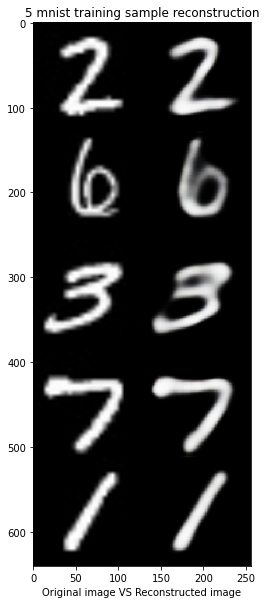

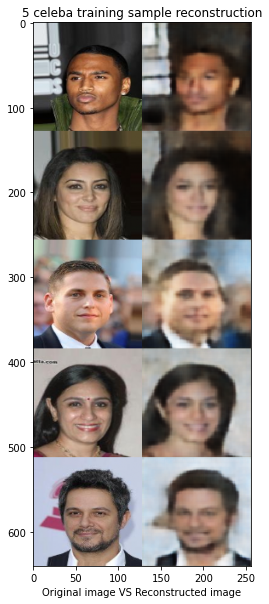

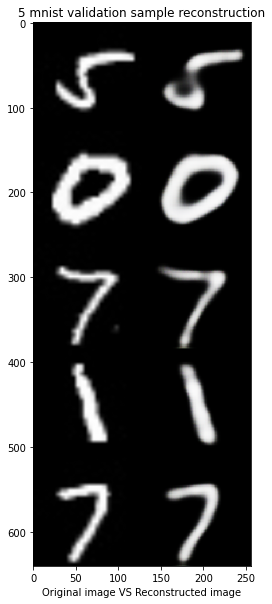

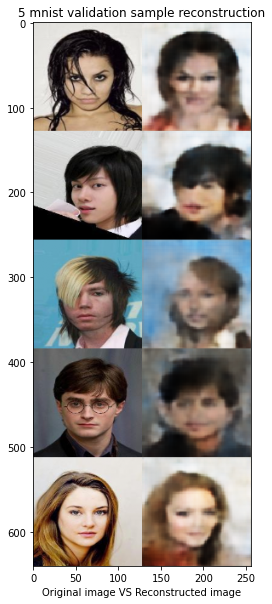

In [ ]:
mnist_random_images = np.array(random.sample(list(mnist_train_dataset),5))
mnistResults = []
for i,data in enumerate(mnist_random_images):
    # WRITE YOUR MNIST TRAINING LOOP HERE.
    #Store image
    mnistResults.append(data.T)
    #Extract image
    img_noisy = torch.FloatTensor(data).to(device)
    #Put image through the trained encoder
    outputs = mnist_autoencoder(img_noisy[None,...])
    #Store results
    mnistResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(mnistResults), 2))
plt.title('5 mnist training sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

celeba_random_images = np.array(random.sample(list(celeba_train_dataset),5))
celebaResults = []
for i,data in enumerate(celeba_random_images):
  # WRITE YOUR CELEBA TRAINING LOOP HERE.
  #Store image
  celebaResults.append(data.T)
  #Extract image
  img_noisy = torch.FloatTensor(data).to(device)
  #Put image through the trained encoder
  outputs = celeba_autoencoder(img_noisy[None,...])
  #Store results
  celebaResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(celebaResults), 2))
plt.title('5 celeba training sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

mnist_random_images = np.array(random.sample(list(mnist_validation_dataset),5))
mnistResults = []
for i,data in enumerate(mnist_random_images):
  # WRITE YOUR MNIST VALIDATION LOOP HERE.
  #Store image
  mnistResults.append(data.T)
  #Extract image
  img_noisy = torch.FloatTensor(data).to(device)
  #Put image through the trained encoder
  outputs = mnist_autoencoder(img_noisy[None,...])
  #Store results
  mnistResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(mnistResults), 2))
plt.title('5 mnist validation sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

celeba_random_images=np.array(random.sample(list(celeba_validation_dataset),5))
celebaResults = []
for i,data in enumerate(celeba_random_images):
  # WRITE YOUR CELEBA VALIDATION LOOP HERE.
  #Store image
  celebaResults.append(data.T)
  #Extract image
  img_noisy = torch.FloatTensor(data).to(device)
  #Put image through the trained encoder
  outputs = celeb_autoencoder(img_noisy[None,...])
  #Store results
  celebResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(celebaResults), 2))
plt.title('5 celeb validation sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

# AFTER YOUR MODEL IS TRAINED, USE THIS SECTION TO ENCODE-DECODE 5 IMAGES EACH FROM CelebA and MNIST.
# PRESENT THE RESULTS IN TWO 5X2 GRID LAYOUTS -- One grid FOR CelebA and another grid for MNIST.
# Grid Format:
# USE 5 ROWS, 2 COLUMNS.
# EACH ROW CORRESPONDS TO 1 TEST IMAGE. FIRST COLUMN SHOULD BE INPUT IMAGE, SECOND COLUMN SHOULD BE RECONSTRUCTED IMAGE
torch.cuda.empty_cache()

## Question 4: Variational AutoEncoder (VAE)

### Part 4a) Add the reparametrization trick to turn the AE into a variational auto-encoder (VAE) **(15 points)**
---
Solve this question by completing the VAE class below

In [ ]:
class VAE(AutoEncoder):
    # IMPLEMENT THIS VAE CLASS
    def __init__(self,bottleneck_size):
        super(VAE, self).__init__(bottleneck_size)
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.
        #Define CNN parameters
        noActivations = 128
        kernel_size=5
        self.noChannels = int(noActivations)
        self.height = int(128 / 2**5)
        self.width = int(128 / 2**5)
        self.flattening = self.noChannels * self.height * self.width
        self.bottleneck = bottleneck_size

        #In this model we included 5 convolutional layers during encoding. We 
        # have to make sure that stride is 2 to half the resolution of the image
        # each layer
        self.modelEnc = nn.Sequential(
            nn.Conv2d(3, int(noActivations/(2**4)), kernel_size=kernel_size, \
                      padding=(kernel_size-1)//2, stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/(2**4)), int(noActivations/(2**3)), \
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/(2**3)), int(noActivations/(2**2)), \
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/(2**2)), int(noActivations/2), \
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(int(noActivations/2), noActivations, \
                      kernel_size=kernel_size, padding=(kernel_size-1)//2, \
                      stride=2),
            nn.Flatten()
        )
        #Create two linear layers to calculate the man and standard deviation
        # of the image
        self.fc1 = nn.Linear(self.flattening, bottleneck_size)
        self.fc2 = nn.Linear(self.flattening, bottleneck_size)
       
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE.
        #Encode image
        code = self.modelEnc(image)
        #Calculate the mean
        mu = self.fc1(code)
        #Calculate the mean which can be taken since the Linear layer will
        # result in the logvar
        std = torch.exp(0.5*self.fc2(code))
        return mu, std
    
    def reparametrization_trick(self,mu,std):
        # WRITE THE REPARAMETRIZATION TRICK HERE.
        #Reparameterize to being able to backpropagate
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        mu, std = self.encoder(image)
        code = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(code)
        return decoded_image, mu, std

### Part 4b) Test it on the CelebA and MNIST dataset by generating 5 samples of each to be shown in no morethan half a page. **(5 points)**
---

#### VAE training cell

Training celeba
Epoch 1 of 200, Train Loss: 0.087, Duration(s): 11.85
Epoch 1 of 200, Validation Loss: 0.076
Epoch 41 of 200, Train Loss: 0.046, Duration(s): 11.58
Epoch 41 of 200, Validation Loss: 0.046
Epoch 81 of 200, Train Loss: 0.042, Duration(s): 11.15
Epoch 81 of 200, Validation Loss: 0.043
Epoch 121 of 200, Train Loss: 0.042, Duration(s): 10.94
Epoch 121 of 200, Validation Loss: 0.043
Epoch 161 of 200, Train Loss: 0.042, Duration(s): 11.42
Epoch 161 of 200, Validation Loss: 0.043
Epoch 200 of 200, Train Loss: 0.041, Duration(s): 11.02
Epoch 200 of 200, Validation Loss: 0.043


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training mnist
Epoch 1 of 200, Train Loss: 0.159, Duration(s): 5.34
Epoch 1 of 200, Validation Loss: 0.103
Epoch 41 of 200, Train Loss: 0.045, Duration(s): 5.27
Epoch 41 of 200, Validation Loss: 0.047
Epoch 81 of 200, Train Loss: 0.042, Duration(s): 5.27
Epoch 81 of 200, Validation Loss: 0.044
Epoch 121 of 200, Train Loss: 0.040, Duration(s): 5.11
Epoch 121 of 200, Validation Loss: 0.041
Epoch 161 of 200, Train Loss: 0.038, Duration(s): 5.39
Epoch 161 of 200, Validation Loss: 0.040
Epoch 200 of 200, Train Loss: 0.037, Duration(s): 5.31
Epoch 200 of 200, Validation Loss: 0.039


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

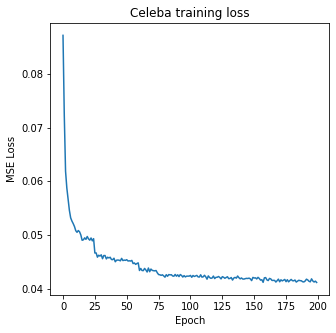

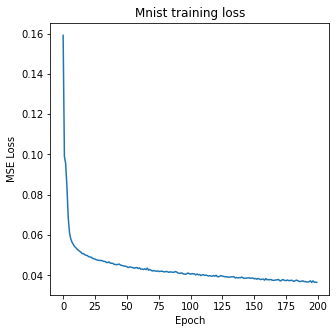

In [ ]:
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
torch.cuda.empty_cache()
def kl_divergence_loss(mu,std):
    # WRITE YOUR KL-DIVERGENCE LOSS CODE HERE
    #We can calculate this by averaging the difference of the current probabilty
    # distribution and a unit gaussian, so that the the model distribution
    # will balance
    P = torch.distributions.Normal(0,1)
    Q = torch.distributions.Normal(mu,std)
    kl = torch.distributions.kl_divergence(P,Q).mean()
    return kl

def reconstruction_loss(input,target):
    # WRITE YOUR L2 RECONSTRUCTION LOSS HERE
    #Implement the pytorch Mean Squared Loss
    mseLoss = nn.MSELoss()
    loss = mseLoss(input, target)
    return loss
    

epochs = 200 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS
# USE THE TORCH API TO WRITE YOUR OPTIMIZER HERE

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

mnist_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder_vae = VAE(mnist_bottleneck_size).to(device)
celeba_autoencoder_vae = VAE(celeba_bottleneck_size).to(device)

mnist_optimizer = torch.optim.Adam(mnist_autoencoder_vae.parameters(), lr=0.00001) 
celeba_optimizer = torch.optim.Adam(celeba_autoencoder_vae.parameters(), lr=0.001) 
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
#Include a scheduler
scheduler_celeba = torch.optim.lr_scheduler.MultiStepLR(celeba_optimizer, \
                                                        milestones=[25,60,75],\
                                                        gamma=0.5)

print("Training celeba")
lossHistoryCeleba = []
for ep in range(epochs):
  #Variables to calculate the loss and the duration
  runningLoss = 0
  timeBeg = time.time()

  for i,data in enumerate(torch_train_celeba):
    # WRITE YOUR CelebA TRAINING LOOP HERE.
    #Extract the images
    img_val = data.float().to(device)
    #Set the gradient to zero
    celeba_optimizer.zero_grad()
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = celeba_autoencoder_vae(img_val)
    #Calculate the loss
    loss = reconstruction_loss(outputs.to(device), img_val) + \
          kl_divergence_loss(mu,std)
    #Backpropagation
    loss.backward()
    #Parameter update
    celeba_optimizer.step()
    #Update loss
    runningLoss += loss.detach().item()

  #Update the scheduler
  scheduler_celeba.step()
  #Average theloss
  lossTrain = runningLoss / len(torch_train_celeba)
  #Add loss to history
  lossHistoryCeleba.append(lossTrain)
  #Calculate duration
  timeTot = time.time() - timeBeg
  #Print epoch
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Train Loss: {:.3f}, Duration(s): {:.2f}'\
          .format( ep+1, epochs, lossTrain, timeTot))

  runningLoss = 0
  for i,data in enumerate(torch_validation_celeba):
    # WRITE YOUR CelebA VALIDATION LOOP HERE.
    #Extract image
    img_val = data.float().to(device)
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = celeba_autoencoder_vae(img_val)
    #Update loss
    l2 = reconstruction_loss(outputs.to(device), img_val).detach().item()
    runningLoss += l2 +  kl_divergence_loss(mu,std).detach().item()

  #Average loss
  lossVal = runningLoss / len(torch_validation_celeba)
  #Print epoch info
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Validation Loss: {:.3f}'.format(ep+1,epochs,lossVal))

#Plot loss history
plt.figure(figsize=(5, 5))
plt.plot(lossHistoryCeleba)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Celeba training loss')

lossHistoryMnist = []
print("Training mnist")
for ep in range(epochs):
    #Variables to calculate the loss and the duration
  runningLoss = 0
  timeBeg = time.time()

  for i,data in enumerate(torch_train_mnist):
    # WRITE YOUR Mnist TRAINING LOOP HERE.
    #Extract the images
    img_val = data.float().to(device)
    #Set the gradient to zero
    mnist_optimizer.zero_grad()
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = mnist_autoencoder_vae(img_val)
    #Calculate the loss
    loss = reconstruction_loss(outputs.to(device), img_val) + \
          kl_divergence_loss(mu,std)
    #Backpropagation
    loss.backward()
    #Parameter update
    mnist_optimizer.step()
    #Update loss
    runningLoss += loss.detach().item()

  #Update the scheduler
  scheduler_mnist.step()
  #Average theloss
  lossTrain = runningLoss / len(torch_train_mnist)
  #Add loss to history
  lossHistoryMnist.append(lossTrain)
  #Calculate duration
  timeTot = time.time() - timeBeg
  #Print epoch
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Train Loss: {:.3f}, Duration(s): {:.2f}'\
          .format(ep+1, epochs, lossTrain, timeTot))

  runningLoss = 0
  for i,data in enumerate(torch_validation_mnist):
    # WRITE YOUR Mnist VALIDATION LOOP HERE.
    #Extract image
    img_val = data.float().to(device)
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = mnist_autoencoder_vae(img_val)
    #Update loss
    l2 = reconstruction_loss(outputs.to(device), img_val).detach().item()
    runningLoss += l2 +  kl_divergence_loss(mu,std).detach().item()

  #Average loss
  lossVal = runningLoss / len(torch_validation_mnist)
  #Print epoch info
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Validation Loss: {:.3f}'.format(ep+1,epochs,lossVal))

#Plot loss history
plt.figure(figsize=(5, 5))
plt.plot(lossHistoryMnist)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Mnist training loss')
torch.cuda.empty_cache()

#### VAE testing cell

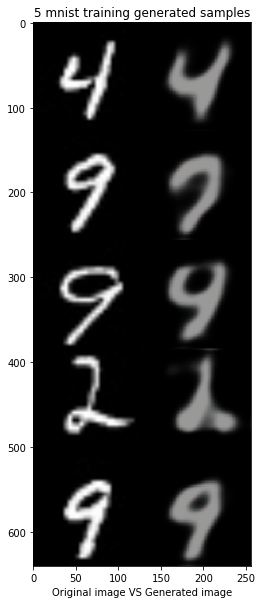

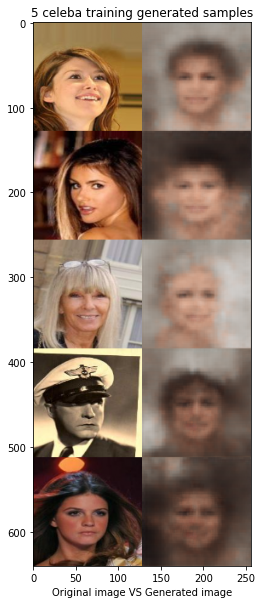

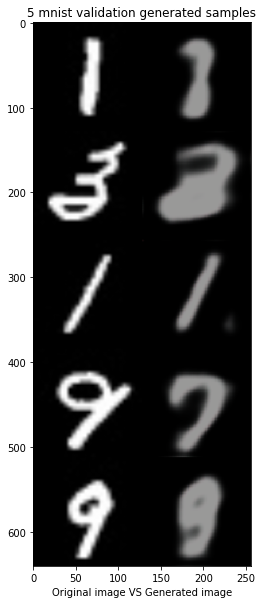

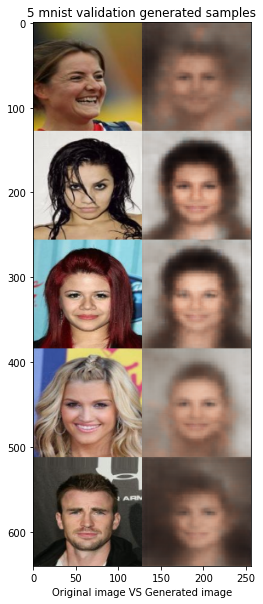

In [ ]:
mnist_random_images = np.array(random.sample(list(mnist_train_dataset),5))
mnistResults = []
for i,data in enumerate(mnist_random_images):
    # WRITE YOUR MNIST TRAINING LOOP HERE.
    #Store image
    mnistResults.append(data.T)
    #Extract image
    img_noisy = torch.FloatTensor(data).to(device)
    #Put image through the trained encoder
    outputs = mnist_autoencoder_vae(img_noisy[None,...])
    #Store results
    mnistResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(mnistResults), 2))
plt.title('5 mnist training sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

celeba_random_images = np.array(random.sample(list(celeba_train_dataset),5))
celebaResults = []
for i,data in enumerate(celeba_random_images):
  # WRITE YOUR CELEBA TRAINING LOOP HERE.
  #Store image
  celebaResults.append(data.T)
  #Extract image
  img_noisy = torch.FloatTensor(data).to(device)
  #Put image through the trained encoder
  outputs = celeba_autoencoder_vae(img_noisy[None,...])
  #Store results
  celebaResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(celebaResults), 2))
plt.title('5 celeba training sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

mnist_random_images = np.array(random.sample(list(mnist_validation_dataset),5))
mnistResults = []
for i,data in enumerate(mnist_random_images):
  # WRITE YOUR MNIST VALIDATION LOOP HERE.
  #Store image
  mnistResults.append(data.T)
  #Extract image
  img_noisy = torch.FloatTensor(data).to(device)
  #Put image through the trained encoder
  outputs = mnist_autoencoder_vae(img_noisy[None,...])
  #Store results
  mnistResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(mnistResults), 2))
plt.title('5 mnist validation sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

celeba_random_images=np.array(random.sample(list(celeba_validation_dataset),5))
celebaResults = []
for i,data in enumerate(celeba_random_images):
  # WRITE YOUR CELEBA VALIDATION LOOP HERE.
  #Store image
  celebaResults.append(data.T)
  #Extract image
  img_noisy = torch.FloatTensor(data).to(device)
  #Put image through the trained encoder
  outputs = celeb_autoencoder_vae(img_noisy[None,...])
  #Store results
  celebResults.append(outputs.cpu().detach().numpy()[0].T)

#Plot the training reconstructions
plt.figure(figsize=(20, 10))
plt.imshow(gallery(np.array(celebaResults), 2))
plt.title('5 celeb validation sample reconstruction')
plt.xlabel('Original image VS Reconstructed image')
plt.show()

# AFTER YOUR MODEL IS TRAINED, USE THIS SECTION TO ENCODE-DECODE 5 IMAGES EACH FROM CelebA and MNIST.
# PRESENT THE RESULTS IN TWO 5X2 GRID LAYOUTS -- One grid FOR CelebA and another grid for MNIST.
# Grid Format:
# USE 5 ROWS, 2 COLUMNS.
# EACH ROW CORRESPONDS TO 1 TEST IMAGE. FIRST COLUMN SHOULD BE INPUT IMAGE, SECOND COLUMN SHOULD BE RECONSTRUCTED IMAGE
torch.cuda.empty_cache()

### Part 4c) Compare the samples from the VAE to the samples of the AE and explain in one sentence what is the difference. **(3 points)**
---
Solve this question by completing and running the cell below with your trained auto-encoder

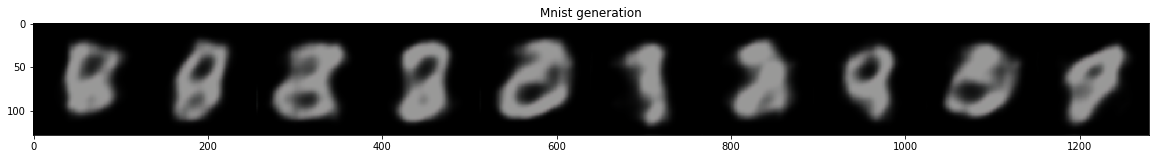

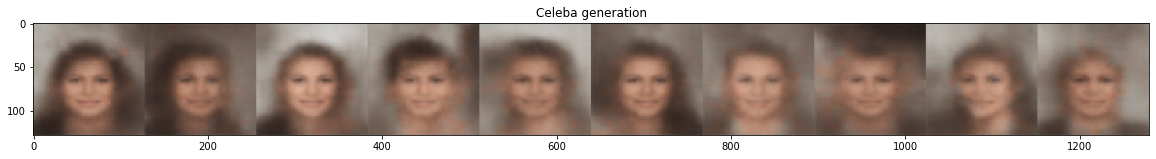

In [ ]:
number_of_samples = 10

random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(3,mnist_bottleneck_size)
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    #Put random code through encoder and store int he final list
    outputs = mnist_autoencoder_vae.decoder(random_normal_code.to(device))
    random_mnist_images.append(outputs.cpu().detach().numpy()[0].T)

#Plot Mnist
plt.figure(figsize=(20, 10))
plt.imshow(gallery_rows(np.array(random_mnist_images), 1))
plt.title('Mnist generation')
plt.show()
    
random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(3,celeba_bottleneck_size)
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    #Put random code through encoder and store int he final list
    outputs = celeba_autoencoder_vae.decoder(random_normal_code.to(device))
    random_celeba_images.append(outputs.cpu().detach().numpy()[0].T)
#Plot Celeba
plt.figure(figsize=(20, 10))
plt.imshow(gallery_rows(np.array(random_celeba_images), 1))
plt.title('Celeba generation')
plt.show()

The resulting images are very different, the AE results in images that look like the original images, and the VAE shows a smoother image with more definition on the face, this can be explained because VAE matches the image to certain probability distributions and AE matches the image to points - this makes sense since the AE aims for an image reconstructor and the VAE is a generative model.

### Part 4d) If it is difficult to make VAE optimization converge, please try Stochastic Gradient Descent, and ADAM. Write no more than three sentences and one plot to argue why one optimizer is better than the other while nothing else was changed. **(3 points)**
---

SGD computes the stochastic gradient descent and Adam is a combination of two variational SGD,  Root Mean Square Propagation (RMSProp) and Adaptive Gradient Algorithm (AdaGrad). This means that Adam employs dynamic bounds on learning rates to achieve a gradual and smooth transition to SGD, and it can adapt the model faster to find an optimised loss. We can see in the image below how Adam can get to a better accuracy over the same number of epochs than SGD.

![](https://drive.google.com/uc?export=view&id=1fUvgEDvXXcAb2A8K089LhIH6Pu1rDOVt)

### Part 4e) Modify your VAE training to use this VGG Perceptual loss, instead of reconstruction loss.  For this loss,you can use the activation from any of thenlayers of VGG - you can choose your list of VGG layers to use, to generate the best results. **(10 points)**
---
Solve this question by writing the VGG Perceptual Loss in the place indicated below

#### VGG Perceptual Loss definition

In [ ]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        vgg = torchvision.models.vgg11(pretrained=True)
        
        # VGG LAYER SELECTION CODE: YOU CAN USE YOUR CHOICE OF VGG-LAYER TO HELP TRAINING, BY ADDING TO blocks AS ILLUSTRATED BELOW.
        blocks.append(vgg.features[:4].eval()) # THIS GIVES ACTIVATION OF VGG LAYER 4
        blocks.append(vgg.features[4:9].eval()) # THIS GIVES ACTIVATION OF VGG LAYER 9
        
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
                
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))

    def forward(self, input, target):
        #input = input.repeat(1, 3, 1, 1)
        #target = target.repeat(1, 3, 1, 1)
        
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        
        # YOU CAN CHANGE THIS SIZE IF YOU WANT TO, INSTEAD OF 224 x 224. CHOOSE YOUR PARAMETERS TO GENERATE BEST RESULTS.
        input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
        target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        
        vgg_perceptual_loss = 0.0
        
        # WRITE YOUR VGG PERCEPTUAL LOSS CODE HERE
        #Relu inplace -> problem
        #
        x1 = self.blocks[0](input)
        y1 = self.blocks[0](target)
        x2 = self.blocks[1](self.blocks[0](input))
        y2 = self.blocks[1](self.blocks[0](target))
        vgg_perceptual_loss = 0.9*torch.nn.functional.mse_loss(x1,y1) + \
                              0.1*torch.nn.functional.mse_loss(x2,y2)

        return vgg_perceptual_loss

#### Training Cell with VGG Loss

Training celeba 
Epoch 1 of 50, Train Loss: 4.735, Duration(s): 15.31
Epoch 1 of 50, Validation Loss: 4.411
Epoch 11 of 50, Train Loss: 4.583, Duration(s): 14.65
Epoch 11 of 50, Validation Loss: 4.440
Epoch 21 of 50, Train Loss: 4.579, Duration(s): 14.81
Epoch 21 of 50, Validation Loss: 4.428
Epoch 31 of 50, Train Loss: 4.567, Duration(s): 14.78
Epoch 31 of 50, Validation Loss: 4.416
Epoch 41 of 50, Train Loss: 4.566, Duration(s): 14.52
Epoch 41 of 50, Validation Loss: 4.416
Epoch 50 of 50, Train Loss: 4.565, Duration(s): 14.88
Epoch 50 of 50, Validation Loss: 4.417
Training mnist
Epoch 1 of 50, Train Loss: 3.871, Duration(s): 7.59
Epoch 1 of 50, Validation Loss: 3.799
Epoch 11 of 50, Train Loss: 1.837, Duration(s): 7.23
Epoch 11 of 50, Validation Loss: 1.858
Epoch 21 of 50, Train Loss: 1.530, Duration(s): 7.19
Epoch 21 of 50, Validation Loss: 1.550
Epoch 31 of 50, Train Loss: 1.183, Duration(s): 7.39
Epoch 31 of 50, Validation Loss: 1.245
Epoch 41 of 50, Train Loss: 0.946, Duration(s)

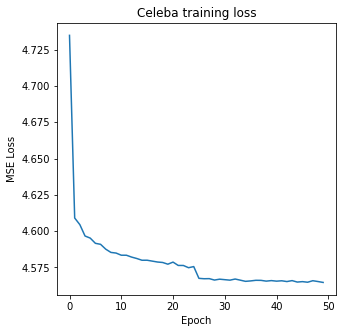

In [ ]:
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
torch.cuda.empty_cache()

epochs = 50 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS
# USE THE TORCH API TO WRITE YOUR OPTIMIZER HERE

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

mnist_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 2000 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder_vgg = VAE(mnist_bottleneck_size).to(device)
celeba_autoencoder_vgg = VAE(celeba_bottleneck_size).to(device)

mnist_optimizer = torch.optim.Adam(mnist_autoencoder_vgg.parameters(), lr=0.00001) 
celeba_optimizer = torch.optim.Adam(celeba_autoencoder_vgg.parameters(), lr=0.001) 
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
#Include a scheduler
scheduler_celeba = torch.optim.lr_scheduler.StepLR(celeba_optimizer, \
                                                        step_size=25,\
                                                        gamma=0.5)
vgg_loss = VGGPerceptualLoss().to(device)
print("Training celeba")
lossHistoryCeleba = []
for ep in range(epochs):
  #Variables to calculate the loss and the duration
  runningLoss = 0
  timeBeg = time.time()

  for i,data in enumerate(torch_train_celeba):
    # WRITE YOUR CelebA TRAINING LOOP HERE.
    #Extract the images
    img_val = data.float().to(device)
    #Set the gradient to zero
    celeba_optimizer.zero_grad()
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = celeba_autoencoder_vgg(img_val)
    #Calculate the loss
    loss = vgg_loss(outputs.to(device), img_val)+  0.01*kl_divergence_loss(mu,std)
    #Backpropagation
    loss.backward()
    #Parameter update
    celeba_optimizer.step()
    #Update loss
    runningLoss += loss.detach().item()

  #Update the scheduler
  scheduler_celeba.step()
  #Average theloss
  lossTrain = runningLoss / len(torch_train_celeba)
  #Add loss to history
  lossHistoryCeleba.append(lossTrain)
  #Calculate duration
  timeTot = time.time() - timeBeg
  #Print epoch
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Train Loss: {:.3f}, Duration(s): {:.2f}'\
          .format(  ep+1, epochs, lossTrain, timeTot))

  runningLoss = 0
  for i,data in enumerate(torch_validation_celeba):
    # WRITE YOUR CelebA VALIDATION LOOP HERE.
    #Extract image
    img_val = data.float().to(device)
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = celeba_autoencoder_vgg(img_val)
    #Update loss
    runningLoss += vgg_loss(outputs.to(device), img_val).detach().item() \
                            + 0.01*kl_divergence_loss(mu,std)

  #Average loss
  lossVal = runningLoss / len(torch_validation_celeba)
  #Print epoch info
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Validation Loss: {:.3f}'.format(ep+1,epochs,lossVal))

#Plot loss history
plt.figure(figsize=(5, 5))
plt.plot(lossHistoryCeleba)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Celeba training loss')

print("Training mnist")
for ep in range(epochs):
    #Variables to calculate the loss and the duration
  runningLoss = 0
  timeBeg = time.time()

  for i,data in enumerate(torch_train_mnist):
    # WRITE YOUR Mnist TRAINING LOOP HERE.
    #Extract the images
    img_val = data.float().to(device)
    #Set the gradient to zero
    mnist_optimizer.zero_grad()
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = mnist_autoencoder_vgg(img_val)
    #Calculate the loss
    loss = vgg_loss(outputs.to(device), img_val) + 0.01*kl_divergence_loss(mu,std)
    #Backpropagation
    loss.backward()
    #Parameter update
    mnist_optimizer.step()
    #Update loss
    runningLoss += loss.detach().item()

  #Average theloss
  lossTrain = runningLoss / len(torch_train_mnist)
  #Calculate duration
  timeTot = time.time() - timeBeg
  #Print epoch
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Train Loss: {:.3f}, Duration(s): {:.2f}'\
          .format(  ep+1, epochs, lossTrain, timeTot))

  runningLoss = 0
  for i,data in enumerate(torch_validation_mnist):
    # WRITE YOUR Mnist VALIDATION LOOP HERE.
    #Extract image
    img_val = data.float().to(device)
    #Put image through CNN which will also return the mean and standard
    # deviation
    outputs, mu, std = mnist_autoencoder_vgg(img_val)
    #Update loss
    runningLoss += vgg_loss(outputs.to(device), img_val).detach().item() \
                    + 0.01*kl_divergence_loss(mu,std)

  #Average loss
  lossVal = runningLoss / len(torch_validation_mnist)
  #Print epoch info
  if ep % (epochs/5) == 0 or ep == epochs-1:
    print('Epoch {} of {}, Validation Loss: {:.3f}'.format(ep+1,epochs,lossVal))


torch.cuda.empty_cache()

#### Testing Cell for VAE with VGG Perceptual Loss

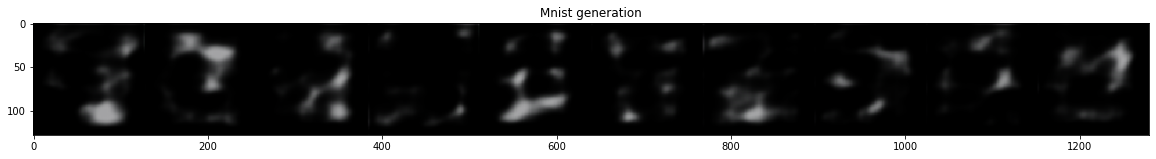

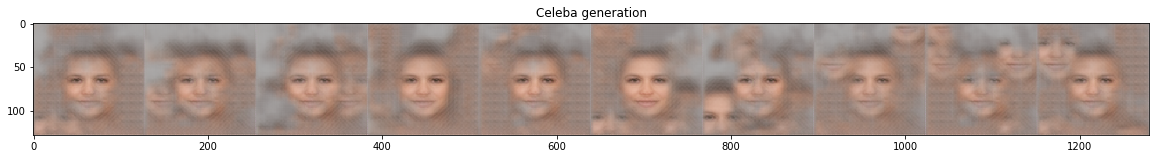

In [ ]:
number_of_samples = 10

random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(3,mnist_bottleneck_size)
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    #Put random code through encoder and store int he final list
    outputs = mnist_autoencoder_vgg.decoder(random_normal_code.to(device))
    random_mnist_images.append(outputs.cpu().detach().numpy()[0].T)

#Plot Mnist
plt.figure(figsize=(20, 10))
plt.imshow(gallery_rows(np.array(random_mnist_images), 1))
plt.title('Mnist generation')
plt.show()
    
random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(3,celeba_bottleneck_size)
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    #Put random code through encoder and store int he final list
    outputs = celeba_autoencoder_vgg.decoder(random_normal_code.to(device))
    random_celeba_images.append(outputs.cpu().detach().numpy()[0].T)
#Plot Celeba
plt.figure(figsize=(20, 10))
plt.imshow(gallery_rows(np.array(random_celeba_images), 1))
plt.title('Celeba generation')
plt.show()

In VAE, we can see that the resulting generated samples represent more the images given from the dataset, as generated images have more variation. The VAE loss puts more focus on image reconstruction than image generation. In VAE with vgg is focusing more on generating an image that resembles the features of the dataset given.

In VAE with vgg, rather than encouraging the pixels of the output image to exactly match the pixels of the target image y, it instead encourages them to have similar feature representations as computed by the loss network. VGG is a pyramidal network and in the deeper layers in the network represent higher-level features and have more importance such as in the celeba, it will focus more on things like the face shape.

It is worth mentioning how the image generation does not work as well in mnist as it does in celeba, in neither VAE or VAE with vgg. This is because the digits are much more different between them and it is hard to find common features to create a generalised mnist structure. To create a valid digit we would need to give a dataset of that single digit instead of all digits to distinguish the key characteristics.

### Part 4f) Document a choice of weighting, (α1,...,αn), used above that you think works best for generating new samples.  This should include image examples, arguing for your design **(10 points)**
---

In my vgg perceptual loss, I chose to put a higher weight in the first block. This is because the first block will prioritise the local features of the image much more than the global ones, for example, in the celeba dataset it will focus on details of the face rather than the overall shape which will help us create a more real face model.

When testing different weights I recoded the loss of celeba and these are the results after 50 epochs:

0.5 first block, 0.5 second block: 14.000

1 first block, 2 second block: 24.909

2 first block, 1 second block: 17.467

0.7 first block, 0.3 second block: 8.814,

0.3 first block, 0.7 second block: 11.814,
 
We can see that the weights have to be normalised to be able to get good loss outputs. Then, we can see that in order to achieve the lowest lost, we need to prioritise the first block. This is because this way we prioritise to get an output more similar to the input.

However, it is clearer to see with the given examples. In the first image, we have prioritised the global features and in the second one, we have prioritised the local. We can see that it is easier to generate a more realistic person when we prioritise local features.

![](https://drive.google.com/uc?export=view&id=1j5MCg8zAgwLZkxewzjQMkJehrXYDeAT4)

![](https://drive.google.com/uc?export=view&id=1Qgn8ZzhulcDQ0fZ3r611r61Bu1JNMQfU)

Apart from this, I also weighted the different loss function to prioritise less the kl difference loss, so that we give more importance to the resulting image’s similarity rather than balancing the distribution of the images.